# Level 1: Local Frog Discovery Tool benchmark notebook

## Challenge Level 1 Overview


Welcome to the 2022 EY Data Science Challenge! This is the first challenge aimed at beginner/intermediate participants that have little to no experience in data science and programming. For more experienced participants, we recommend undertaking challenge level 2 outlined [here](Model_Level_2.ipynb). If you choose to undertake the first level of the challenge, you will be developing a species distribution model (SDM) for one Australian frog species using only variables from the TerraClimate dataset. A species distribution model is a specific type of machine learning model that aims to predict the distribution of a biological species across geographic space and time. Such models have become increasingly important in conservation efforts globally to better understand and map the habitats of species of interest, particularly threatened or endangered species. 

The frog species identified for this challenge is **Litoria fallax**, the eastern dwarf tree frog pictured below. In addition to assisting our understanding of this specific frog species, a successful frog SDM will have broader implications in quantifying biodiversity. This is because frogs are incredibly sensitive to environmental changes, so any changes in their species distribution may indicate an underlying change to biodiversity in the area. 

<center>
<img src="pictures/Litoria_fallax.jpg" width="500" height="340">
</center>

<br>

**Challenge aim:** to develop a species distribution model for litoria fallax across Australia using weather data from the TerraClimate dataset.

| Challenge | Locations                     | Spatial Res        | Species          | Satellite Data                                                |
|-----------|-------------------------------|--------------------|------------------|---------------------------------------------------------------|
|***1***    | Australia                     | Coarse (4km)  | 1 species  | TerraClimate                                                  |
|2     | Australia, Costa Rica,<br>South Africa | Fine (10m)   | 15 species     | TerraClimate, Sentinel-2,<br>Land cover, water extent, elevation |

In this notebook, we will demonstrate a basic model workflow that can act as a starting point for the challenge. As specified in the first row of the table above, we will restrict this model to regions in Australia at coarse resolution (4kmx4km), predicting one species against the rest of the 5 specified Australian species using only [TerraClimate](https://planetarycomputer.microsoft.com/dataset/terraclimate) predictor variables. In this demonstation, we will be using four features from the TerraClimate dataset, the maximum monthly temperature, the minimum monthly temperature, the mean monthly precipitation, and the mean soil moisture, and will train a logistic regression model with these data. The TerraClimate data is sampled at a monthly temporal resolution, so metrics are calculated over the time dimension to simplify the features. We restrict this analysis to a five year window from the start of 2015 to the end of 2019, and will make the assumption that frog occurrences within that time period are representative of the entire time period (i.e. the frogs take longer than 5 years to move). 


Most of the functions present in this notebook were adapted from the following notebooks:
- [Training Dataset Summary](supplementary_notebooks/dataset_summary.ipynb)
- [TerraClimate/Weather](supplementary_notebooks/TerraClimate.ipynb)

Again, it must be noted that this notebook is just a starting point. We make plenty of assumptions in this notebook that you may not think are best for solving the challenge effectively. You are encouraged to modify these functions, to rewrite them completely, or to try a different approach entirely.


## Load in dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take a while. 

In [46]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt

# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

# Geospatial
import contextily as cx
import xarray as xr
import zarr # Not referenced, but required for xarray

# Import Planetary Computer tools
import fsspec
import pystac

# Other
import os
import zipfile
from itertools import cycle

# Path to data folder with provided material
data_path = 'level_1_challenge'

## Response Variable

Before we can build our model, we need to load in the frog occurrences data and generate our response variable. To do this, we first need to unzip the training data and store it on our machine. Then we can write a function that abstracts the loading process, with the option of providing a bounding box to only take those occurrences within a region of interest.


In [47]:
#if not os.path.exists(data_path+'/training_data/'):
#    os.mkdir(data_path+'/training_data/')
#    with zipfile.ZipFile(data_path+'/GBIF_training_data.zip', 'r') as zip_ref:
#        zip_ref.extractall(data_path+'/training_data/')
        
def filter_bbox(frogs, bbox):
    frogs = frogs[lambda x: 
        (x.decimalLongitude >= bbox[0]) &
        (x.decimalLatitude >= bbox[1]) &
        (x.decimalLongitude <= bbox[2]) &
        (x.decimalLatitude <= bbox[3])
    ]
    return frogs

def get_frogs(file, year_range=None, bbox=None):
    """Returns the dataframe of all frog occurrences for the bounding box specified."""
    columns = [
        'gbifID','eventDate','country','continent','stateProvince',
        'decimalLatitude','decimalLongitude','species'
    ]
    country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }
    continent_names = {
        'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
        'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
        'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
        'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
    }
    frogs = (
        pd.read_csv('occurrence.txt', sep='\t', parse_dates=['eventDate'])
        .assign(
            country =  lambda x: x.countryCode.map(country_names),
            continent =  lambda x: x.countryCode.map(continent_names),
            species = lambda x: x.species.str.title()
        )
        [columns]
    )
    if year_range is not None:
        frogs = frogs[lambda x: 
            (x.eventDate.dt.year >= year_range[0]) & 
            (x.eventDate.dt.year <= year_range[1])
        ]
    if bbox is not None:
        frogs = filter_bbox(frogs, bbox)
    return frogs

### Sub-sampling

For this demonstration, we will constrain our search to frogs in the Greater Sydney area found between the start of 2015 to the end of 2019. This gives a varied landscape of bushland, plains, rivers, and urban areas. This is done by providing `year_range` and `bbox` parameters to the get_frogs function we defined above.

In [48]:
# Define the bounding box for Greater Sydney, NSW
region_name = 'Australia'

#min_lon, min_lat = (143.784035, -38.1591)  # Lower-left corner
#max_lon, max_lat = (153.624262, -15.45)  # Upper-right corner
#bbox = (min_lon, min_lat, max_lon, max_lat)

# Load in data
all_frog_data = get_frogs('occurrence.txt', year_range=(2015, 2019))
all_frog_data

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species
3,2265778539,2018-07-21 21:24:21,Costa Rica,Central America,Puntarenas,9.756705,-84.613363,Agalychnis Callidryas
5,2251945867,2018-05-27 20:31:39,Panama,Central America,Bocas del Toro,9.517162,-82.580823,Agalychnis Callidryas
6,1836625681,2018-02-25 06:17:00,Mozambique,Africa,Maputo,-25.077627,32.065052,Chiromantis Xerampelina
7,1944370584,2018-04-18 19:05:00,Australia,Australia,New South Wales,-33.693144,151.320884,Litoria Fallax
9,1913177945,2016-01-28 11:55:00,Costa Rica,Central America,Limón,10.549700,-83.506400,Agalychnis Callidryas
...,...,...,...,...,...,...,...,...
193738,1337957278,2015-05-26 00:00:00,Costa Rica,Central America,NaN,10.547559,-83.505875,Agalychnis Callidryas
193740,2833101444,2017-02-05 00:00:00,Costa Rica,Central America,NaN,10.055360,-83.550603,Agalychnis Callidryas
193741,2834084086,2019-03-03 00:00:00,Costa Rica,Central America,NaN,8.367381,-83.280201,Dendrobates Auratus
193742,2836394361,2018-07-19 00:00:00,Costa Rica,Central America,NaN,10.365915,-83.399889,Agalychnis Callidryas


In [68]:
all_frog_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65165 entries, 3 to 193747
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gbifID            65165 non-null  int64         
 1   eventDate         65165 non-null  datetime64[ns]
 2   country           65165 non-null  object        
 3   continent         65165 non-null  object        
 4   stateProvince     65022 non-null  object        
 5   decimalLatitude   65165 non-null  float64       
 6   decimalLongitude  65165 non-null  float64       
 7   species           65165 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 4.5+ MB


## Filter Frog in Australia

In [64]:
au_frog_data = all_frog_data[all_frog_data['continent'] == 'Australia']
au_frog_data.head(20)

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species
7,1944370584,2018-04-18 19:05:00,Australia,Australia,New South Wales,-33.693144,151.320884,Litoria Fallax
17,2423011701,2019-08-28 09:24:00,Australia,Australia,New South Wales,-33.925746,151.164082,Litoria Fallax
21,2236299662,2018-02-13 23:02:00,Australia,Australia,New South Wales,-31.732415,152.088515,Litoria Fallax
23,2563750401,2017-10-25 21:07:00,Australia,Australia,New South Wales,-32.968624,151.644194,Litoria Fallax
33,1850994254,2017-11-30 08:35:00,Australia,Australia,New South Wales,-33.093048,151.416300,Litoria Fallax
40,2456512415,2016-04-17 11:12:00,Australia,Australia,Queensland,-27.476426,152.977687,Litoria Fallax
43,2465173866,2019-11-22 14:03:00,Australia,Australia,Tasmania,-41.011667,144.618333,Crinia Signifera
53,3031765405,2018-02-20 15:20:00,Australia,Australia,Queensland,-27.400618,152.800944,Litoria Fallax
116,2596664057,2018-11-28 00:00:00,Australia,Australia,Australian Capital Territory,-35.817770,148.936030,Crinia Signifera
120,2596664207,2018-11-29 00:00:00,Australia,Australia,Australian Capital Territory,-35.706270,148.886660,Crinia Signifera


## Plot All

In [53]:
def plot_species(fig, ax, frog_data, region_name, cmap_params={'alpha':0.5}, scatter_params={'alpha':0.5}):
    # Bar chart
    bar_data = frog_data.species.value_counts()
    barchart = ax[1].bar(bar_data.index.str.replace(' ', '\n'), bar_data)

    # Colour cycle to ensure colors match in both plots
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        species_name = bar_data.index[i]
        if len(species_name) > 19:
            display_name = species_name.replace(' ', '\n')
        else:
            display_name = species_name
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{display_name}\nCount: {bar_data[i]}")
        filt = frog_data.species == species_name
        # Scatter plot
        ax[0].scatter(
            frog_data[filt].decimalLongitude, 
            frog_data[filt].decimalLatitude, 
            marker='.', 
            color=color['color'],
            **scatter_params
        )

    # Add other features
    ax[0].set_title(f"Frog occurrences for {region_name}")
    # ax[0].set_xticklabels([])
    # ax[0].set_yticklabels([])
    ax[1].set_title(f"Frog species distribution in {region_name}")
    cx.add_basemap(ax[0], crs={'init':'epsg:4326'}, **cmap_params) # Add basemap
    ax[1].set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax[1].legend()
    
    
def plot_barchart(bar_data, ax, bar_params={}, fold_text=True):
    barchart = ax.bar(bar_data.index, bar_data, **bar_params)
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        var_name = bar_data.index[i]
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{var_name}\nCount: {bar_data[i]}")
    ax.set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax.legend()

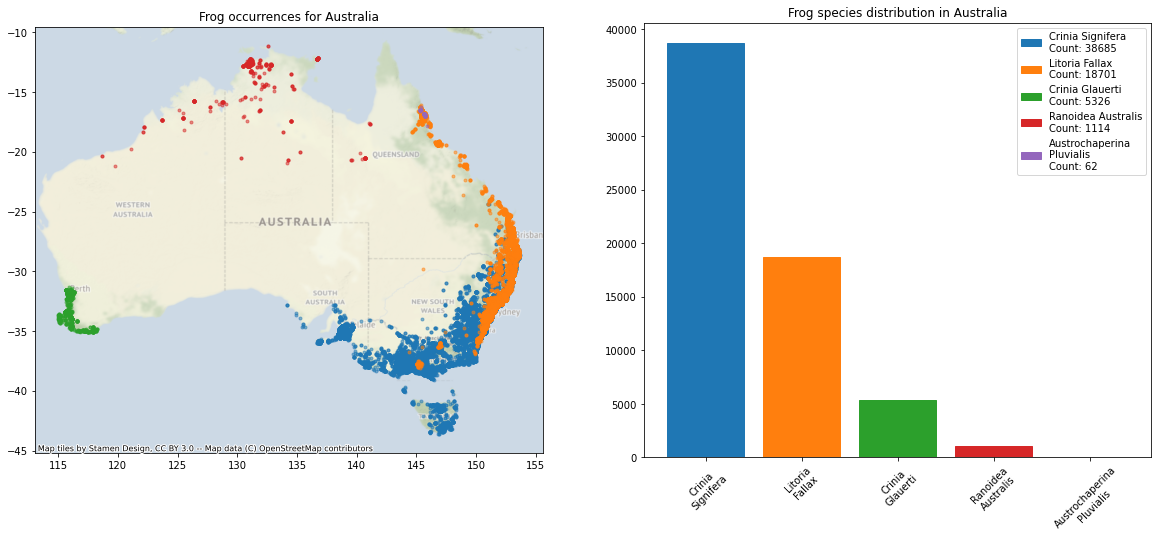

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
plot_species(fig, ax, au_frog_data, region_name)

## Filter Box of Litoria Fallax

In [55]:
min_lon = min(au_frog_data[au_frog_data['species'] == 'Litoria Fallax']['decimalLongitude'])
max_lon = max(au_frog_data[au_frog_data['species'] == 'Litoria Fallax']['decimalLongitude'])
min_lat = min(au_frog_data[au_frog_data['species'] == 'Litoria Fallax']['decimalLatitude'])
max_lat = max(au_frog_data[au_frog_data['species'] == 'Litoria Fallax']['decimalLatitude'])
              
print(min_lon, max_lon)
print(min_lat, max_lat)

144.35052 153.614
-38.12691 -16.048582


In [56]:
target_data = au_frog_data[(au_frog_data['decimalLongitude'] >= min_lon) & (au_frog_data['decimalLongitude'] <= max_lon) & 
                           (au_frog_data['decimalLatitude'] >= min_lat) & (au_frog_data['decimalLatitude'] <= max_lat)]
target_data

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species
7,1944370584,2018-04-18 19:05:00,Australia,Australia,New South Wales,-33.693144,151.320884,Litoria Fallax
17,2423011701,2019-08-28 09:24:00,Australia,Australia,New South Wales,-33.925746,151.164082,Litoria Fallax
21,2236299662,2018-02-13 23:02:00,Australia,Australia,New South Wales,-31.732415,152.088515,Litoria Fallax
23,2563750401,2017-10-25 21:07:00,Australia,Australia,New South Wales,-32.968624,151.644194,Litoria Fallax
33,1850994254,2017-11-30 08:35:00,Australia,Australia,New South Wales,-33.093048,151.416300,Litoria Fallax
...,...,...,...,...,...,...,...,...
193507,3408189344,2019-12-24 21:22:00,Australia,Australia,Queensland,-26.754987,152.839291,Litoria Fallax
193510,2981077059,2018-11-22 03:59:00,Australia,Australia,New South Wales,-34.791600,150.779300,Litoria Fallax
193515,2573827842,2019-04-22 18:11:00,Australia,Australia,Queensland,-27.497691,153.018211,Litoria Fallax
193719,2420099324,2016-09-17 00:00:00,Australia,Australia,Victoria,-37.845236,144.354168,Crinia Signifera


In [57]:
print(min(target_data.decimalLongitude))
print(max(target_data.decimalLongitude))
print(min(target_data.decimalLatitude))
print(max(target_data.decimalLatitude))

144.35052
153.614
-38.12691
-16.048582


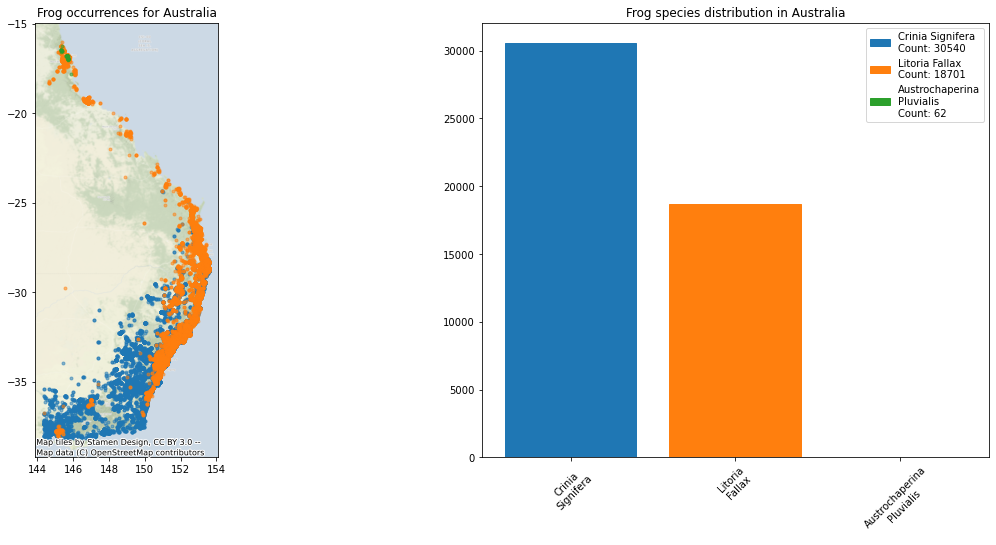

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
plot_species(fig, ax, target_data, region_name)

## Sampling bias

In [79]:
target_species = 'Litoria Fallax'

target_data = (
    target_data
    # Assign the occurrenceStatus to 1 for the target species and 0 for all other species.
    # as well as a key for joining (later)
    .assign(
        occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0)
    )
)
target_data

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus
7,1944370584,2018-04-18 19:05:00,Australia,Australia,New South Wales,-33.693144,151.320884,Litoria Fallax,1
17,2423011701,2019-08-28 09:24:00,Australia,Australia,New South Wales,-33.925746,151.164082,Litoria Fallax,1
21,2236299662,2018-02-13 23:02:00,Australia,Australia,New South Wales,-31.732415,152.088515,Litoria Fallax,1
23,2563750401,2017-10-25 21:07:00,Australia,Australia,New South Wales,-32.968624,151.644194,Litoria Fallax,1
33,1850994254,2017-11-30 08:35:00,Australia,Australia,New South Wales,-33.093048,151.416300,Litoria Fallax,1
...,...,...,...,...,...,...,...,...,...
193507,3408189344,2019-12-24 21:22:00,Australia,Australia,Queensland,-26.754987,152.839291,Litoria Fallax,1
193510,2981077059,2018-11-22 03:59:00,Australia,Australia,New South Wales,-34.791600,150.779300,Litoria Fallax,1
193515,2573827842,2019-04-22 18:11:00,Australia,Australia,Queensland,-27.497691,153.018211,Litoria Fallax,1
193719,2420099324,2016-09-17 00:00:00,Australia,Australia,Victoria,-37.845236,144.354168,Crinia Signifera,0


In [80]:
target_data.to_csv('target_data.csv', index=False)

In [67]:
target_data[target_data['species'] == 'Litoria Fallax'].tail(20)

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species
193386,3108847976,2019-10-03 00:00:00,Australia,Australia,New South Wales,-33.405000,151.459000,Litoria Fallax
193389,3108866024,2019-01-19 00:00:00,Australia,Australia,New South Wales,-30.100909,153.161828,Litoria Fallax
193399,3108885555,2017-11-12 00:00:00,Australia,Australia,New South Wales,-28.704900,152.691000,Litoria Fallax
193403,3108855591,2017-12-11 00:00:00,Australia,Australia,New South Wales,-28.596500,153.234000,Litoria Fallax
193411,2421529376,2018-11-07 00:00:00,Australia,Australia,New South Wales,-32.468573,151.085213,Litoria Fallax
193424,2421382752,2019-02-15 00:00:00,Australia,Australia,New South Wales,-33.838575,151.071142,Litoria Fallax
193425,3108880747,2018-12-14 00:00:00,Australia,Australia,New South Wales,-33.324700,151.364000,Litoria Fallax
193431,3108915921,2017-11-12 00:00:00,Australia,Australia,New South Wales,-33.699966,151.043100,Litoria Fallax
193446,3108864544,2018-09-08 00:00:00,Australia,Australia,New South Wales,-28.727500,153.170000,Litoria Fallax
193449,3108873586,2018-02-09 00:00:00,Australia,Australia,New South Wales,-29.454800,153.205000,Litoria Fallax


In [65]:
target_data.head(10)

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species
7,1944370584,2018-04-18 19:05:00,Australia,Australia,New South Wales,-33.693144,151.320884,Litoria Fallax
17,2423011701,2019-08-28 09:24:00,Australia,Australia,New South Wales,-33.925746,151.164082,Litoria Fallax
21,2236299662,2018-02-13 23:02:00,Australia,Australia,New South Wales,-31.732415,152.088515,Litoria Fallax
23,2563750401,2017-10-25 21:07:00,Australia,Australia,New South Wales,-32.968624,151.644194,Litoria Fallax
33,1850994254,2017-11-30 08:35:00,Australia,Australia,New South Wales,-33.093048,151.416300,Litoria Fallax
40,2456512415,2016-04-17 11:12:00,Australia,Australia,Queensland,-27.476426,152.977687,Litoria Fallax
53,3031765405,2018-02-20 15:20:00,Australia,Australia,Queensland,-27.400618,152.800944,Litoria Fallax
116,2596664057,2018-11-28 00:00:00,Australia,Australia,Australian Capital Territory,-35.817770,148.936030,Crinia Signifera
120,2596664207,2018-11-29 00:00:00,Australia,Australia,Australian Capital Territory,-35.706270,148.886660,Crinia Signifera
149,1253333795,2015-09-24 00:00:00,Australia,Australia,New South Wales,-30.280630,150.166360,Crinia Signifera
